In [50]:
import pandas as pd
import os
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
from pyAudioAnalysis import MidTermFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import statistics
#Resources used:
    #https://opensource.com/article/19/9/audio-processing-machine-learning-python
    #Basically spectrum is super important bc it uses Fourier transformation to make graphs 
    #based on frequency rather than time
    #MFCC = Mel Frequency Cepstral Coefficients, peaks are esssentially the most important info

### Audio Analysis Function and Setting up Dataframes

In [90]:
def audio_analysis(audio_file, dataset): #This is the essential function for finding the MFCCs of each recording
    '''This function takes in a .WAV recording, audio_file, and a dataframe, dataset, 
    and finds and appends the average of each MFCC, the dialect region of the speaker, and the sentence code.'''
    coefficient = [] #temporary list to which all the MFCC averages will be appended 
    path = "./darpa-timit-acousticphonetic-continuous-speech/data/" #All the data is contained in this file
    audio_path = path + audio_file #Now we lead the function to the specific recording
    [Fs, x] = audioBasicIO.read_audio_file(audio_path) #Converting the audio into data 
    F, f_names = ShortTermFeatures.feature_extraction(x, Fs, 0.050*Fs, 0.025*Fs) #Finding all the features at each frame rate
    for i in range(f_names.index('mfcc_1'),f_names.index('mfcc_13')+1): #Iterating through the list of features to append
        coefficient.append(sum(F[i])/len(F[i])) #the average of the list of one type of MFCC found at each frame rate
    audio_file = audio_file.split('/') #Finding the dialect region and appending it
    coefficient.append(audio_file[1])
    audio_file = audio_file[3].split('.') #Finding the sentence code and appending it
    coefficient.append(audio_file[0])
    dataset.append(coefficient) #Appending whole list to given dataset

In [91]:
train = []
test = []
#from https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory
path = './darpa-timit-acousticphonetic-continuous-speech/data/'
for datatype in os.listdir(path): #this path leads us to the folder data, with only TEST and TRAIN folders
    path = path + datatype #path now includes TRAIN or TEST
    if datatype != '.DS_Store':
        for accent in os.listdir(path): #Leads to folders of each accent district 
            path = path + '/' + accent #Path now includes one of the accent districts
            if accent != '.DS_Store':
                for person in os.listdir(path):
                    if person != '.DS_Store':
                        path = path + '/' + person #Now includes one person's file
                        for file in os.listdir(path):
                            if file.endswith(".wav"): #Looking for person's recordings
                                file_path = datatype + '/' + accent + '/' + person + '/' + file #setting up for audio_analysis
                                if datatype.lower() == 'train': #finding out which list to append the data to
                                    audio_analysis(file_path, train)
                                else:
                                    audio_analysis(file_path, test)
                    path = './darpa-timit-acousticphonetic-continuous-speech/data/' + datatype + '/' + accent #Resetting path
            path = './darpa-timit-acousticphonetic-continuous-speech/data/' + datatype
    path = './darpa-timit-acousticphonetic-continuous-speech/data/'

In [101]:
df_train = pd.DataFrame(train) #Turning the lists into dataframes
df_test = pd.DataFrame(test)
#Giving columns names
df_train.rename(columns = {0: 'MFCC 1', 1: 'MFCC 2', 2: 'MFCC 3', 3: 'MFCC 4', 4: 'MFCC 5', 
                          5: 'MFCC 6', 6: 'MFCC 7', 7: 'MFCC 8', 8: 'MFCC 9', 9: 'MFCC 10', 10: 'MFCC 11', 
                          11: 'MFCC 12', 12: 'MFCC 13', 13: 'Region', 14:'Sentence'}, inplace = True)
df_test.rename(columns = {0: 'MFCC 1', 1: 'MFCC 2', 2: 'MFCC 3', 3: 'MFCC 4', 4: 'MFCC 5', 
                          5: 'MFCC 6', 6: 'MFCC 7', 7: 'MFCC 8', 8: 'MFCC 9', 9: 'MFCC 10', 10: 'MFCC 11', 
                          11: 'MFCC 12', 12: 'MFCC 13', 13: 'Region', 14:'Sentence'}, inplace = True)

In [597]:
def analyze(tr, te):
    '''This functions takes in a training dataframe, tr, and a testing dataframe, te, and runs them through GridSearchCV between 1 and 30 n_neighbors, inclusive. It returns R^2, the model, X_tr, X_te, y_tr, y_te in this order.'''
    X_tr, X_te = tr.drop(columns = ['Sentence','Region']), te.drop(columns = ['Sentence', 'Region']) #Dropping additional information and labels
    sc_X = StandardScaler()
    X_tr = sc_X.fit_transform(X_tr)
    X_te = sc_X.transform(X_te)
    y_tr, y_te = tr['Sentence'], te['Sentence']
    param_grid = {'n_neighbors': range(1, 30)}
    model = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='accuracy', iid = True)
    model = model.fit(X_tr, y_tr)
    model = model.best_estimator_
    model.fit(X_tr, y_tr)
    r2 = model.score(X_te, y_te)
    return r2, model, X_tr, X_te, y_tr, y_te

### Running KNN on All Data

In [598]:
analyze(df_train, df_test)[0:2] #Only printing R^2 and model

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


(0.17559523809523808,
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                      weights='uniform'))

### Dropping Sentences with Only One Speaker (Fail)

In [185]:
#Finding all sentences that only appear once
unique = dict()
for value in df_train['Sentence']: #The problem was that this was trained only on df_train
    unique[value] = unique.get(value,0)+1 #So df_test had sentences that the model hadn't been trained on
uniques = []
for key, value in unique.items():
    if value == 1:
        uniques.append(key)

In [599]:
#from https://stackoverflow.com/questions/27965295/dropping-rows-from-dataframe-based-on-a-not-in-condition
#Deleting all rows with information from a sentence that only appears once
train_less, test_less = df_train[~df_train['Sentence'].isin(uniques)], df_test[~df_test['Sentence'].isin(uniques)] 
analyze(train_less, test_less)[0:2]

(0.175,
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                      weights='uniform'))

### Using Only Two Sentences

In [600]:
small = ['SA1','SA2']
small_train = df_train[df_train['Sentence'].isin(small)].reset_index()
small_test = df_test[df_test['Sentence'].isin(small)].reset_index()
analyzen = analyze(small_train, small_test) #Saving all the returned values

In [625]:
analyzen[0] #R^2

0.9017857142857143

In [606]:
#Printing how many recordings were classified incorrectly per speaker dialect region
yts_values = [] #Y values from testing dataset
regions = {}
for value in analyzen[5]: #Looking in Y values from the testing set
    yts_values.append(value)
for i in range(len(analyzen[3])): #X_test
    if analyzen[1].predict([analyzen[3][i]])[0] != yts_values[i]: #If prediction != truth
        regions[small_test.iloc[i]['Region']] = regions.get(small_test.iloc[i]['Region'],0)+1 #Up the incorrect count on region
r_tuples = []
for region, amount in regions.items():
    r_tuples.append((amount, region))
r_tuples.sort(reverse = True) #Finding dialect region with highest confusion
for tupler in r_tuples:
    print(tupler)

(10, 'DR2')
(7, 'DR4')
(5, 'DR7')
(4, 'DR8')
(3, 'DR5')
(2, 'DR3')
(2, 'DR1')


![](Speakers.png)

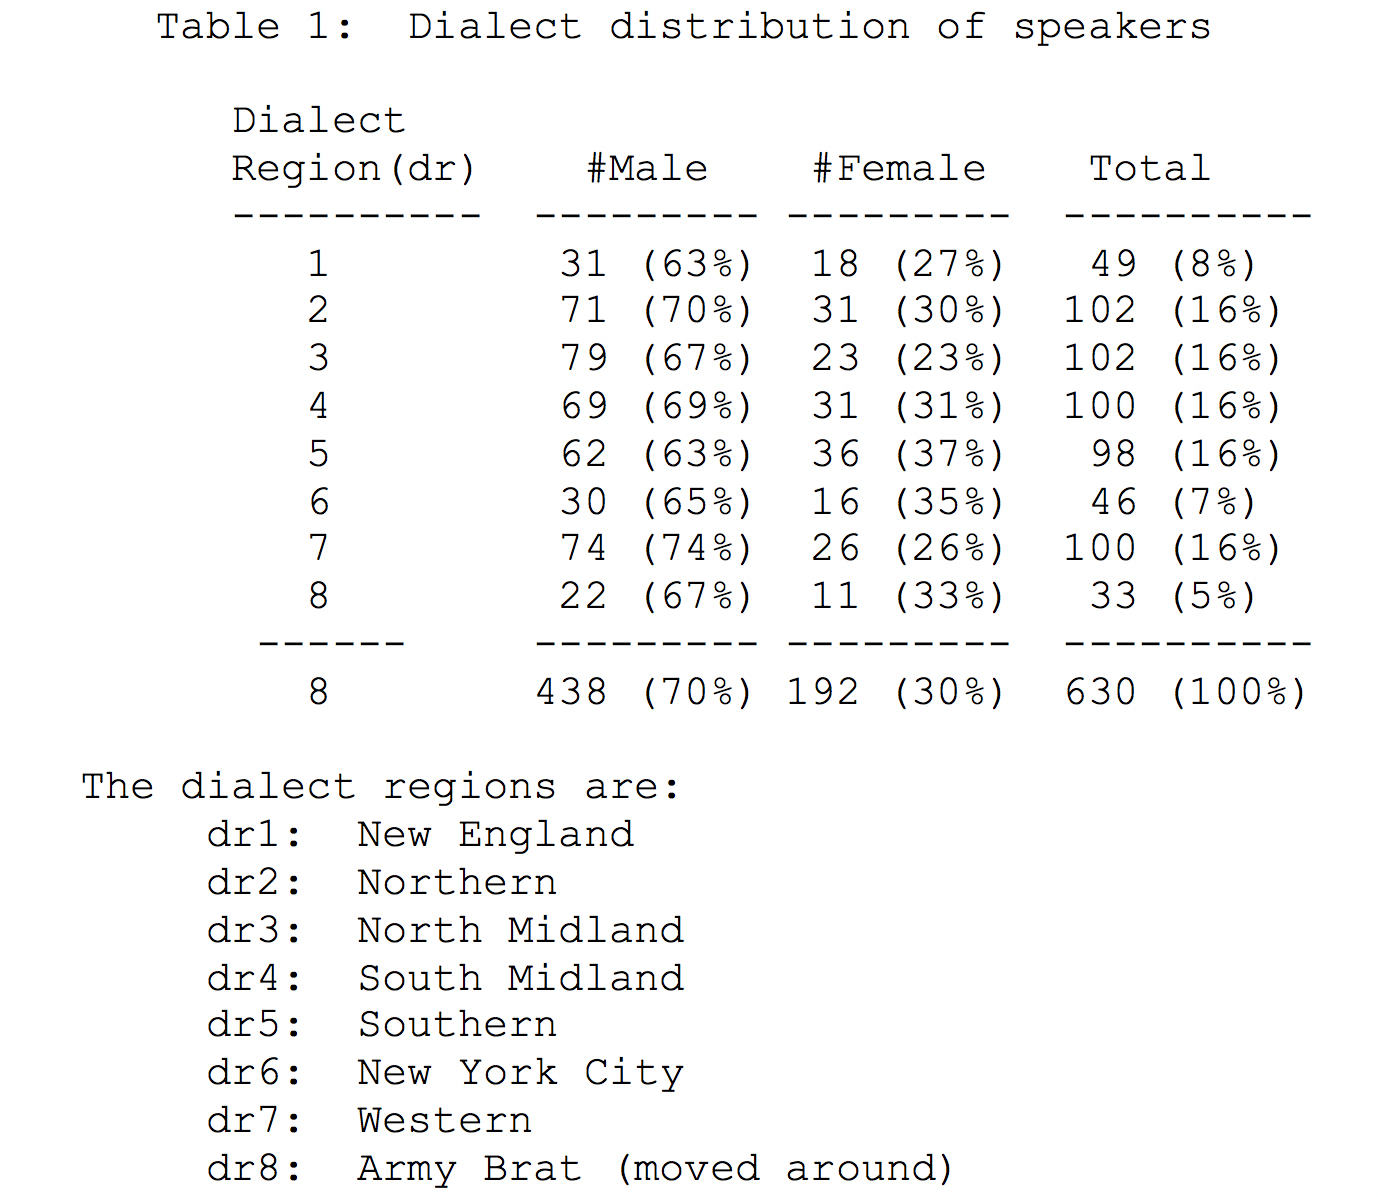

### Using Only Sentences with 7 Speakers or More (Actual)

In [411]:
#Finding which sentences we want; almost the same approach as dropping sentences with one speaker (the less datasets)
tups = []
unique = dict()
for value in df_train['Sentence']:
    unique[value] = unique.get(value,0)+1
for sentence, num in unique.items():
    tups.append((num, sentence))
tups.sort(reverse = True)
sentences = []
for tup in tups:
    sentences.append(tup[1])
good_sen = []
for tup in tups:
    if tup[0] != 1: #Unlike the less datasets, here we're looking for sentences in this list, not not in the list
        good_sen.append(tup[1]) #Ensures only sentences found in the train set are used in the test set

In [602]:
train_new, test_new = df_train[df_train['Sentence'].isin(good_sen)].reset_index(), df_test[df_test['Sentence'].isin(good_sen)].reset_index()
analysisn = analyze(train_new, test_new)

In [624]:
analysisn[0] #R^2

0.8809523809523809

In [457]:
#Finding which sentences get confused the most along with regions, like above
wrong = dict()
for i in range(len(analysisn[3])): 
    if analysisn[1].predict([analysisn[3][i]])[0] != analysisn[5][i]:
        wrong[i] = [analysisn[1].predict([analysisn[3][i]])[0], analysisn[5][i], test_new.iloc[i]['Region']]

In [458]:
wrong
#Seems that SA2 is the one most often classified as SA1, and the one most confused, regardless of dialect region

{11: ['SA1', 'SA2', 'DR4'],
 17: ['SA1', 'SA2', 'DR4'],
 19: ['SA1', 'SA2', 'DR4'],
 21: ['SA1', 'SA2', 'DR4'],
 25: ['SA1', 'SA2', 'DR4'],
 49: ['SX169', 'SA2', 'DR4'],
 51: ['SA1', 'SA2', 'DR4'],
 57: ['SA1', 'SA2', 'DR4'],
 85: ['SA1', 'SA2', 'DR3'],
 109: ['SA1', 'SA2', 'DR3'],
 119: ['SA1', 'SA2', 'DR2'],
 125: ['SA1', 'SA2', 'DR2'],
 127: ['SA1', 'SA2', 'DR2'],
 137: ['SA1', 'SA2', 'DR2'],
 141: ['SA1', 'SA2', 'DR2'],
 159: ['SA1', 'SA2', 'DR2'],
 162: ['SA2', 'SA1', 'DR2'],
 164: ['SA2', 'SA1', 'DR2'],
 167: ['SA1', 'SA2', 'DR2'],
 169: ['SA1', 'SA2', 'DR5'],
 187: ['SA1', 'SA2', 'DR5'],
 207: ['SA1', 'SA2', 'DR5'],
 208: ['SA2', 'SA1', 'DR5'],
 223: ['SA1', 'SA2', 'DR5'],
 227: ['SA1', 'SA2', 'DR7'],
 247: ['SA1', 'SA2', 'DR7'],
 261: ['SA1', 'SA2', 'DR7'],
 265: ['SA1', 'SA2', 'DR7'],
 277: ['SA1', 'SA2', 'DR6'],
 281: ['SA1', 'SA2', 'DR6'],
 285: ['SA1', 'SA2', 'DR6'],
 291: ['SA1', 'SA2', 'DR6'],
 295: ['SA1', 'SA2', 'DR1'],
 298: ['SX423', 'SA1', 'DR1'],
 302: ['SX123', 'SA

In [459]:
#Finding how many recordings are confused per dialect region 
tuples = []
counting = {}
for line, values in wrong.items():
    counting[values[2]] = counting.get(values[2],0)+1
for region, num in counting.items():
    tuples.append((num, region))
tuples.sort(reverse = True)
tuples

[(9, 'DR2'),
 (8, 'DR4'),
 (5, 'DR5'),
 (4, 'DR8'),
 (4, 'DR7'),
 (4, 'DR6'),
 (4, 'DR1'),
 (2, 'DR3')]

In [559]:
#Finding how many sentences are confused per dialect region only counting real SA2s
tuples = []
counting = {}
for line, values in wrong.items():
    if values[1] == "SA2":
        counting[values[2]] = counting.get(values[2],0)+1
for region, num in counting.items():
    tuples.append((num, region))
tuples.sort(reverse = True)
tuples

[(8, 'DR4'),
 (7, 'DR2'),
 (4, 'DR8'),
 (4, 'DR7'),
 (4, 'DR6'),
 (4, 'DR5'),
 (2, 'DR3'),
 (2, 'DR1')]

### Why is SA2 Confused for SA1 the Most?

In [484]:
prompts = open('./darpa-timit-acousticphonetic-continuous-speech/PROMPTS.TXT').readlines() #Looking at all the prompts

In [613]:
sentences = []
for values in wrong.values():
    for value in values:
        if value[0] != 'D':
            sentences.append((value.lower()))

In [615]:
#Finding the prompts corresponding to each classification and truth in the wrong dictionary
for line in prompts:
    words = line.split()
    for word in words:
        if '(' in word:
            if word[1:len(word)-1] in set(sentences):
                print(line)

She had your dark suit in greasy wash water all year. (sa1)

Don't ask me to carry an oily rag like that. (sa2)

A screwdriver is made from vodka and orange juice. (sx123)

How would you evaluate this algebraic expression? (sx169)

Smash lightbulbs and their cash value will diminish to nothing. (sx423)



In [117]:
def comparison(s1, s2):
    '''This function takes in two sentence codes, s1 and s2, and prints out the average value and standard deviation 
    for each of their MFCCs.'''
    js1 = df_train[df_train['Sentence'] == s1] #Creating dataframes with just that sentence
    js2 = df_train[df_train['Sentence'] == s2]
    js1_list = []
    js2_list = []
    st1 = []
    st2 = []
    for i in range(13):
        js1_list.append(sum(js1[js1.columns[i]])/len(js1[js1.columns[i]])) #Averaging each MFCC
        st1.append(statistics.stdev(js1[jsa1.columns[i]])) #Finding the standard deviation of all the values
        js2_list.append(sum(js2[js2.columns[i]])/len(js2[js2.columns[i]]))
        st2.append(statistics.stdev(js2[js2.columns[i]]))
    for i in range(len(js1_list)): #Printing out the results neatly
        print(f'MFCC {i+1}: \n\t{s1}: \n\tAverage: {js1_list[i]} \n\tSTDEV: {st1[i]} \n\n\t{s2}:' 
              f'\n\tAverage: {js2_list[i]} \n\tSTDEV: {st2[i]}')
    diff = []
    for i in range(len(js1_list)): #Printing out the differences between the averages and the average difference
        diff.append(js1_list[i] - js2_list[i])
        print(f'MFCC {i+1} Difference: {js1_list[i] - js2_list[i]}')
    print(f"Average Difference: {sum(diff)/len(diff)}")

In [619]:
print(len(df_train[df_train['Sentence'] == 'SA2']), len(df_train[df_train['Sentence'] == 'SA1']))
#Same exact amount, so not classifying based on majority

462 462


In [591]:
comparison('SA2','SA1')

MFCC 1: 
	SA2: 
	Average: -27.269362008978998 
	STDEV: 0.9800720584423628 

	SA1: 
	Average: -27.88326024289322 
	STDEV: 0.8007001356331079
MFCC 2: 
	SA2: 
	Average: 1.3401671437367364 
	STDEV: 0.31257094077670544 

	SA1: 
	Average: 1.3777030319336623 
	STDEV: 0.27224112816919377
MFCC 3: 
	SA2: 
	Average: -0.745376532329107 
	STDEV: 0.21970016633506914 

	SA1: 
	Average: -0.49285957229137034 
	STDEV: 0.20305755728032795
MFCC 4: 
	SA2: 
	Average: -0.3586397996917549 
	STDEV: 0.16771421498013464 

	SA1: 
	Average: -0.3764837183609035 
	STDEV: 0.14533625513567058
MFCC 5: 
	SA2: 
	Average: -0.34725964253696007 
	STDEV: 0.1831066482711602 

	SA1: 
	Average: -0.36337824832220406 
	STDEV: 0.1476543414542233
MFCC 6: 
	SA2: 
	Average: 0.18865980915837194 
	STDEV: 0.1186781392839252 

	SA1: 
	Average: 0.045251839093579486 
	STDEV: 0.09827439250788184
MFCC 7: 
	SA2: 
	Average: -0.08314473288526332 
	STDEV: 0.14046789064647233 

	SA1: 
	Average: -0.1578023307782444 
	STDEV: 0.08253915801940151
MFC

In [593]:
comparison('SA1','SX423')

MFCC 1: 
	SA1: 
	Average: -27.88326024289322 
	STDEV: 0.8007001356331079 

	SX423: 
	Average: -28.468047138797495 
	STDEV: 0.7261496495264632
MFCC 2: 
	SA1: 
	Average: 1.3777030319336623 
	STDEV: 0.27224112816919377 

	SX423: 
	Average: 1.1085703908888505 
	STDEV: 0.27684686891990895
MFCC 3: 
	SA1: 
	Average: -0.49285957229137034 
	STDEV: 0.20305755728032795 

	SX423: 
	Average: -0.4775128646437622 
	STDEV: 0.25073006219383387
MFCC 4: 
	SA1: 
	Average: -0.3764837183609035 
	STDEV: 0.14533625513567058 

	SX423: 
	Average: -0.5690085281946544 
	STDEV: 0.16813990619958183
MFCC 5: 
	SA1: 
	Average: -0.36337824832220406 
	STDEV: 0.1476543414542233 

	SX423: 
	Average: -0.09091883889401432 
	STDEV: 0.13391770604699196
MFCC 6: 
	SA1: 
	Average: 0.045251839093579486 
	STDEV: 0.09827439250788184 

	SX423: 
	Average: 0.006651287395862427 
	STDEV: 0.07228290418655249
MFCC 7: 
	SA1: 
	Average: -0.1578023307782444 
	STDEV: 0.08253915801940151 

	SX423: 
	Average: -0.04399521867252373 
	STDEV: 0.126

In [595]:
comparison('SA1','SX169')

MFCC 1: 
	SA1: 
	Average: -27.88326024289322 
	STDEV: 0.8007001356331079 

	SX169: 
	Average: -28.318589874002694 
	STDEV: 1.622693503123459
MFCC 2: 
	SA1: 
	Average: 1.3777030319336623 
	STDEV: 0.27224112816919377 

	SX169: 
	Average: 1.2188917561558341 
	STDEV: 0.40402297728911
MFCC 3: 
	SA1: 
	Average: -0.49285957229137034 
	STDEV: 0.20305755728032795 

	SX169: 
	Average: -0.5075033599634942 
	STDEV: 0.13315183276492362
MFCC 4: 
	SA1: 
	Average: -0.3764837183609035 
	STDEV: 0.14533625513567058 

	SX169: 
	Average: -0.32569003200059876 
	STDEV: 0.18157537421139205
MFCC 5: 
	SA1: 
	Average: -0.36337824832220406 
	STDEV: 0.1476543414542233 

	SX169: 
	Average: -0.3793009189926164 
	STDEV: 0.180880398162388
MFCC 6: 
	SA1: 
	Average: 0.045251839093579486 
	STDEV: 0.09827439250788184 

	SX169: 
	Average: 0.07184747461830913 
	STDEV: 0.09763579906035624
MFCC 7: 
	SA1: 
	Average: -0.1578023307782444 
	STDEV: 0.08253915801940151 

	SX169: 
	Average: -0.09932645906742167 
	STDEV: 0.1146416005

In [596]:
comparison('SA1','SX123')

MFCC 1: 
	SA1: 
	Average: -27.88326024289322 
	STDEV: 0.8007001356331079 

	SX123: 
	Average: -28.200820284768987 
	STDEV: 0.32458993318428475
MFCC 2: 
	SA1: 
	Average: 1.3777030319336623 
	STDEV: 0.27224112816919377 

	SX123: 
	Average: 1.2282991041036404 
	STDEV: 0.19119085219757004
MFCC 3: 
	SA1: 
	Average: -0.49285957229137034 
	STDEV: 0.20305755728032795 

	SX123: 
	Average: -0.48777460194392613 
	STDEV: 0.18762141216904665
MFCC 4: 
	SA1: 
	Average: -0.3764837183609035 
	STDEV: 0.14533625513567058 

	SX123: 
	Average: -0.2153595098380216 
	STDEV: 0.1382456680751276
MFCC 5: 
	SA1: 
	Average: -0.36337824832220406 
	STDEV: 0.1476543414542233 

	SX123: 
	Average: -0.3261167297732002 
	STDEV: 0.11903708012867394
MFCC 6: 
	SA1: 
	Average: 0.045251839093579486 
	STDEV: 0.09827439250788184 

	SX123: 
	Average: 0.05458422602631165 
	STDEV: 0.10529195299934693
MFCC 7: 
	SA1: 
	Average: -0.1578023307782444 
	STDEV: 0.08253915801940151 

	SX123: 
	Average: 0.004464583368557907 
	STDEV: 0.1518

### Chord Diagram (Troubleshooting and Result)

PCA Dimensionality Reduction Issue: would create a matrix with just zeroes.

Analyzing file 1 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA1 --- 1.wav
Analyzing file 2 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA1 --- 2.wav
Analyzing file 3 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA1 --- 3.wav
Analyzing file 4 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA1 --- 4.wav
Analyzing file 5 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA1 --- 5.wav
Analyzing file 6 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA1 --- 6.wav
Analyzing file 7 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA2 --- 1.wav
Analyzing file 8 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA2 --- 2.wav
Analyzing file 9 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA2 --- 3.wav
Analyzing file 10 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA2 --- 4.wav
Analyzing file 11 of 12: ./da

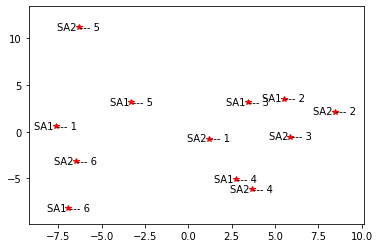

In [112]:
from pyAudioAnalysis import audioVisualization
#Comparing SA1 and SA2 sentences from the same people with a DR4 accent (South Midland)
audioVisualization.visualizeFeaturesFolder("./darpa-timit-acousticphonetic-continuous-speech/Visualize", 'pca')
#SA1 is blue and SA2 is red
#With threshold at 0

In [88]:
#Cell used to print out each variable to identify the issue
#Currently showing successful attempt to change the function so that the original SM2 values get to the final
#data matrix
visualizeFeaturesFolder("./darpa-timit-acousticphonetic-continuous-speech/Visualize", 'pca', priorKnowledge = "none")

Analyzing file 1 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA1 --- 1.wav
Analyzing file 2 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA1 --- 2.wav
Analyzing file 3 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA1 --- 3.wav
Analyzing file 4 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA1 --- 4.wav
Analyzing file 5 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA1 --- 5.wav
Analyzing file 6 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA1 --- 6.wav
Analyzing file 7 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA2 --- 1.wav
Analyzing file 8 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA2 --- 2.wav
Analyzing file 9 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA2 --- 3.wav
Analyzing file 10 of 12: ./darpa-timit-acousticphonetic-continuous-speech/Visualize/SA2 --- 4.wav
Analyzing file 11 of 12: ./da

LDA Dimensionality Reduction Method Issues

In [89]:
#Using LDA as the dimensionality reduction method would never work, giving me this error
audioVisualization.visualizeFeaturesFolder("./darpa-timit-acousticphonetic-continuous-speech/Visualize", 'lda')

ValueError: The number of samples must be more than the number of classes.

In [92]:
#Cell used to print out each variable to identify the issue
#Currently showing identical error, demonstrating I've found the root of the problem (can be seen in the comments
#surrounding the line noted in the error)
visualizeFeaturesFolder("./darpa-timit-acousticphonetic-continuous-speech/Visualize", 'lda', priorKnowledge = "none")

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


ValueError: The number of samples must be more than the number of classes.

Actual Functions (With Explanations in Comments as to Reasons for Errors/Problems)

In [113]:
#Additional functions necessary to run visualizeFeaturesFolder
def generateColorMap():
    '''
    This function generates a 256 jet colormap of HTML-like
    hex string colors (e.g. FF88AA)
    '''
    Map = cm.jet(np.arange(256))
    stringColors = []
    for i in range(Map.shape[0]):
        rgb = (int(255*Map[i][0]), int(255*Map[i][1]), int(255*Map[i][2]))
        if (sys.version_info > (3, 0)):
            stringColors.append((struct.pack('BBB', *rgb).hex())) # python 3
        else:
            stringColors.append(
                struct.pack('BBB', *rgb).encode('hex'))  # python2

    return stringColors


def levenshtein(str1, s2):
    '''
    Distance between two strings
    '''
    N1 = len(str1)
    N2 = len(s2)

    stringRange = [range(N1 + 1)] * (N2 + 1)
    for i in range(N2 + 1):
        stringRange[i] = range(i,i + N1 + 1)
    for i in range(0,N2):
        for j in range(0,N1):
            if str1[j] == s2[i]:
                stringRange[i+1][j+1] = min(stringRange[i+1][j] + 1,
                                            stringRange[i][j+1] + 1,
                                            stringRange[i][j])
            else:
                stringRange[i+1][j+1] = min(stringRange[i+1][j] + 1,
                                            stringRange[i][j+1] + 1,
                                            stringRange[i][j] + 1)
    return stringRange[N2][N1]


def text_list_to_colors(names):
    '''
    Generates a list of colors based on a list of names (strings). Similar strings correspond to similar colors.
    '''
    # STEP A: compute strings distance between all combnations of strings
    Dnames = np.zeros( (len(names), len(names)) )
    for i in range(len(names)):
        for j in range(len(names)):
            Dnames[i,j] = 1 - 2.0 * levenshtein(names[i], names[j]) / float(len(names[i]+names[j]))

    # STEP B: pca dimanesionality reduction to a single-dimension (from the distance space)
    pca = sklearn.decomposition.PCA(n_components = 1)
    pca.fit(Dnames)    
    
    # STEP C: mapping of 1-dimensional values to colors in a jet-colormap
    textToColor = pca.transform(Dnames)
    textToColor = 255 * (textToColor - textToColor.min()) / (textToColor.max() - textToColor.min())
    textmaps = generateColorMap();
    colors = [textmaps[int(c)] for c in textToColor]
    return colors


def text_list_to_colors_simple(names):
    '''
    Generates a list of colors based on a list of names (strings). Similar strings correspond to similar colors. 
    '''
    uNames = list(set(names))
    uNames.sort()
    textToColor = [ uNames.index(n) for n in names ]
    textToColor = np.array(textToColor)
    textToColor = 255 * (textToColor - textToColor.min()) / \
                  (textToColor.max() - textToColor.min())
    textmaps = generateColorMap();
    colors = [textmaps[int(c)] for c in textToColor]
    return colors


def chordialDiagram(fileStr, SM, Threshold, names, namesCategories):
    '''
    Generates a d3js chordial diagram that illustrates similarites
    '''
    colors = text_list_to_colors_simple(namesCategories)
    SM2 = SM.copy()
    SM2 = (SM2 + SM2.T) / 2.0
    print(SM2)
    for i in range(SM2.shape[0]):
        M = Threshold
#         a = np.sort(SM2[i,:])[::-1] #commented out in original
#         M = np.mean(a[0:int(SM2.shape[1]/3+1)])
        SM2[i, SM2[i, :] < M] = 0;
    dirChordial = fileStr + "_Chordial"
    if not os.path.isdir(dirChordial):
        os.mkdir(dirChordial)
    jsonPath         = dirChordial + os.sep + "matrix.json"
    namesPath        = dirChordial + os.sep + "Names.csv"
    print("\nSM2 New", SM2)
    jsonSMMatrix = simplejson.dumps(SM2.tolist())
    print(jsonSMMatrix)
    print('Matrix', jsonSMMatrix)
    print(jsonSMMatrix)
    f = open(jsonPath,'w'); f.write(jsonSMMatrix);  f.close()
    f = open(namesPath,'w'); f.write("name,color\n"); 
    for i, n in enumerate(names):
        f.write("{0:s},{1:s}\n".format(n,"#"+str(colors[i])))
    f.close()

#     shutil.copyfile(os.path.join(os.path.dirname(os.path.realpath(__file__)),
#                                  "data", "similarities.html"),
#                     dirChordial+os.sep+"similarities.html")
#     shutil.copyfile(os.path.join(os.path.dirname(os.path.realpath(__file__)),
#                                  "data",
#                                  "style.css"),
#                     dirChordial+os.sep+"style.css")

In [114]:
#Imports
from pyAudioAnalysis import MidTermFeatures as aF
import ntpath
from pyAudioAnalysis import audioTrainTest as aT
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.spatial import distance
import matplotlib.cm as cm
import sys
import shutil, struct, simplejson
#Actual function that is giving me trouble—most of it is coded out because I was trying to narrow down the issue
#and I didn't need the additional code and didn't want it to keep catching my eye or make it difficult to swithc
#between cells
def visualizeFeaturesFolder(folder, dimReductionMethod, priorKnowledge = "none"):
    '''
    This function generates a chordial visualization for the recordings of the provided path.
    ARGUMENTS:
        - folder:        path of the folder that contains the WAV files to be processed
        - dimReductionMethod:    method used to reduce the dimension of the initial feature space before computing the similarity.
        - priorKnowledge:    if this is set equal to "artist"
    '''
    if dimReductionMethod=="pca":
        allMtFeatures, wavFilesList, _ = aF.directory_feature_extraction(folder, 30.0, 30.0, 0.050, 0.050, compute_beat = True)
        if allMtFeatures.shape[0]==0:
            print("Error: No data found! Check input folder")
            return
        
        namesCategoryToVisualize = [ntpath.basename(w).replace('.wav','').split(" --- ")[0] for w in wavFilesList]; 
        namesToVisualize       = [ntpath.basename(w).replace('.wav','') for w in wavFilesList]; 

        (F, MEAN, STD) = aT.normalizeFeatures([allMtFeatures])
        F = np.concatenate(F)
        
        # check that the new PCA dimension is at most equal to the number of samples
        K1 = 2
        K2 = 10
        if K1 > F.shape[0]: #This is correct in our case, 12
            K1 = F.shape[0]
        if K2 > F.shape[0]:
            K2 = F.shape[0]
        pca1 = sklearn.decomposition.PCA(n_components = K1) #Pretty good so far, getting numbers and shape right
        pca1.fit(F)        
        pca2 = sklearn.decomposition.PCA(n_components = K2)
        pca2.fit(F) 


        finalDims = pca1.transform(F)
        finalDims2 = pca2.transform(F)

    else:    
        allMtFeatures, Ys, wavFilesList = aF.directory_feature_extraction_no_avg(folder, 20.0, 5.0, 0.040, 0.040) # long-term statistics cannot be applied in this context (LDA needs mid-term features)
        if allMtFeatures.shape[0]==0:
            print("Error: No data found! Check input folder")
            return
        
        namesCategoryToVisualize = [ntpath.basename(w).replace('.wav','').split(" --- ")[0] for w in wavFilesList]; 
        namesToVisualize       = [ntpath.basename(w).replace('.wav','') for w in wavFilesList]; 
        print(Ys) #The issue with the LDA option seems to be that, instead of using the namesCategoryToVisualize 
                  #as the label as the guide says, it takes each sample to be an individual recording
        ldaLabels = Ys
        if priorKnowledge=="artist":
            uNamesCategoryToVisualize = list(set(namesCategoryToVisualize))
            YsNew = np.zeros( Ys.shape )
            for i, uname in enumerate(uNamesCategoryToVisualize):        # for each unique artist name:
                indicesUCategories = [j for j, x in enumerate(namesCategoryToVisualize) if x == uname]
                for j in indicesUCategories:
                    indices = np.nonzero(Ys==j)
                    YsNew[indices] = i
            ldaLabels = YsNew #This assumes that artist names/classifications will be given under priorKnowledge
                              #though that assumption is never mentioned in the guide either

        (F, MEAN, STD) = aT.normalizeFeatures([allMtFeatures])
        F = np.array(F[0])

        clf = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=10)
        clf.fit(F, ldaLabels)    
        reducedDims =  clf.transform(F)
        print(reducedDims) #Results in same exact issue as the cell with the actual code

#         pca = sklearn.decomposition.PCA(n_components = 2)
#         pca.fit(reducedDims)
#         reducedDims = pca.transform(reducedDims)

#         # TODO: CHECK THIS ... SHOULD LDA USED IN SEMI-SUPERVISED ONLY????

#         uLabels = np.sort(np.unique((Ys)))        # uLabels must have as many labels as the number of wavFilesList elements
#         reducedDimsAvg = np.zeros( (uLabels.shape[0], reducedDims.shape[1] ) )
#         finalDims = np.zeros( (uLabels.shape[0], 2) ) 
#         for i, u in enumerate(uLabels):
#             indices = [j for j, x in enumerate(Ys) if x == u]
#             f = reducedDims[indices, :]
#             finalDims[i, :] = f.mean(axis=0)
#         finalDims2 = reducedDims

#     for i in range(finalDims.shape[0]): #This is what keeps printing out the graphs           
#         plt.text(finalDims[i,0], finalDims[i,1], ntpath.basename(wavFilesList[i].replace('.wav','')), horizontalalignment='center', verticalalignment='center', fontsize=10)
#         plt.plot(finalDims[i,0], finalDims[i,1], '*r')
#     plt.xlim([1.2*finalDims[:,0].min(), 1.2*finalDims[:,0].max()])
#     plt.ylim([1.2*finalDims[:,1].min(), 1.2*finalDims[:,1].max()])            
#     plt.show()

    SM = 1.0 - distance.squareform(distance.pdist(finalDims2, 'cosine')) #Still has correct values and complete
    for i in range(SM.shape[0]):
        SM[i,i] = 0.0; #Seems to simply be zeroing values when its the distance between the same point
    

    chordialDiagram("visualization", SM, 0, namesToVisualize, namesCategoryToVisualize) #Here the thershold 
                                                                                            #should be changed

#     SM = 1.0 - distance.squareform(distance.pdist(F, 'cosine'))
#     for i in range(SM.shape[0]):
#         SM[i,i] = 0.0;
#     chordialDiagram("visualizationInitial", SM, 0.10, namesToVisualize, namesCategoryToVisualize) #as here

#     # plot super-categories (i.e. artistname
#     uNamesCategoryToVisualize = sorted(list(set(namesCategoryToVisualize)))
#     finalDimsGroup = np.zeros( (len(uNamesCategoryToVisualize), finalDims2.shape[1] ) )
#     for i, uname in enumerate(uNamesCategoryToVisualize):
#         indices = [j for j, x in enumerate(namesCategoryToVisualize) if x == uname]
#         f = finalDims2[indices, :]
#         finalDimsGroup[i, :] = f.mean(axis=0)
#     SMgroup = 1.0 - distance.squareform(distance.pdist(finalDimsGroup, 'cosine'))
#     for i in range(SMgroup.shape[0]):
#         SMgroup[i,i] = 0.0;
#     chordialDiagram("visualizationGroup", SMgroup, 0.1, uNamesCategoryToVisualize, uNamesCategoryToVisualize) #and here
